# Question 2 : Large Scale Stochastic Dominance

In [4]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [5]:
# df = pd.read_excel(r'C:\Users\aayus\Documents\GitHub\StochOpt\stochastic-dominance\returns_data.xlsx')
# returns = df.iloc[:,1:].to_numpy()[1:]
# print(returns)

In [6]:
returns = np.array([[ 0.004, -0.025,  0.009,  0.012,  0.047, -0.019,  0.006, -0.037,
         0.025,  0.021,  0.017,  0.019],
       [ 0.014,  0.   , -0.039,  0.016, -0.006,  0.07 , -0.021, -0.022,
         0.019,  0.025,  0.054,  0.04 ],
       [ 0.001,  0.006,  0.005,  0.019,  0.016,  0.057, -0.052,  0.027,
         0.039,  0.   ,  0.011,  0.002],
       [-0.012, -0.021,  0.062,  0.036, -0.002, -0.038,  0.015, -0.003,
         0.024,  0.012,  0.048, -0.007],
       [-0.043,  0.005,  0.023,  0.   ,  0.023,  0.04 ,  0.034,  0.029,
        -0.013, -0.04 ,  0.011,  0.003],
       [ 0.015, -0.027, -0.01 , -0.027,  0.002,  0.038,  0.056, -0.004,
         0.08 ,  0.001,  0.013,  0.026],
       [-0.001,  0.011,  0.056, -0.024,  0.019, -0.048, -0.015,  0.019,
         0.062,  0.023,  0.002, -0.017],
       [ 0.039,  0.03 ,  0.003, -0.004,  0.016, -0.021,  0.003,  0.018,
        -0.026, -0.022,  0.026,  0.073],
       [ 0.017,  0.02 , -0.024, -0.004,  0.019,  0.039, -0.03 ,  0.025,
         0.021,  0.054, -0.011,  0.056],
       [ 0.108, -0.003,  0.061,  0.008,  0.024, -0.037, -0.013,  0.053,
        -0.009, -0.021,  0.026, -0.009]])

In [ ]:
class StochasticDominance(ConstrainedBasedStrategy):

    def __init__(self,benchmark_srategy:ConstrainedBasedStrategy=EqualyWeighted(),long_only=True):
       

        self.results = None
        self.array = None
        self.num_assets = None
        self.num_senarios = None
        self.array_transpose = None
        self.investment_amount = None
        self.strategy = benchmark_srategy
        self.long_only = long_only
        self.results = None
        
    def get_optimal_allocations(self,returns_data:pd.DataFrame,investment_amount:int=1):

        self.array = returns_data.to_numpy()
        self.num_assets = len(self.array[:,0])
        self.num_senarios = len(self.array[0,:])
        self.array_transpose = np.transpose(self.array)
        self.investment_amount = investment_amount
        bench_mark_weights = self.strategy.get_optimal_allocations(returns_data,investment_amount)

        
        self.results = self.optimize(bench_mark_weights,long_only=self.long_only)
        return self.results

    def optimize(self,bench_mark_weights,long_only=True):

        assets = self.num_assets
        senarios = self.num_senarios
        returns = self.array_transpose
        mean = np.resize(self.array.mean(axis=1),(self.num_assets,1))

        # Y_weights = (1/assets)*(np.ones((assets,1)))
        Y_returns = np.sort(((returns)@bench_mark_weights).flatten())
        V = []
        for eta in Y_returns:
            v_j = np.sum((eta-Y_returns)[Y_returns< eta])/(len(Y_returns))
            V.append(v_j)

        weights  = cp.Variable(shape=(assets,1),name="weights")
        S = cp.Variable(shape=(senarios,senarios),name="slack")
        X_returns = returns@weights

        constraints = []
        for j,eta in enumerate(Y_returns):
            for i,x in enumerate(X_returns):
                constraints.append(x+S[i,j]>=eta)

        for j,v_j in enumerate(V):
            constraints.append((1/(len(Y_returns)))*cp.sum(S[:,j])<=v_j)

        if long_only:
            constraints.append(weights>=0)
        constraints.extend([cp.sum(weights)==1,S>=0])

        objective = cp.Maximize((mean.T@weights))
        problem = cp.Problem(objective, constraints)
        problem.solve()
        return weights.value.flatten()

In [7]:
mean_returns= np.resize(returns.mean(axis=1),(10,1))
print("mean",mean_returns)

mean [[0.00658333]
 [0.0125    ]
 [0.01091667]
 [0.0095    ]
 [0.006     ]
 [0.01358333]
 [0.00725   ]
 [0.01125   ]
 [0.01516667]
 [0.01566667]]


In [18]:
assets = 10
senarios = 12

In [19]:
# Compute of E(max(0,n-y))
Y_weights = (1/assets)*(np.ones((assets,1)))
Y_returns = np.sort(((returns.T)@Y_weights).flatten())
V = []
for eta in Y_returns:
    v_j = np.sum((eta-Y_returns)[Y_returns< eta])/(len(Y_returns))
    V.append(v_j)

In [20]:
print(V)

[np.float64(0.0), np.float64(0.00010833333333333311), np.float64(0.0007083333333333333), np.float64(0.0012333333333333337), np.float64(0.002166666666666667), np.float64(0.0031666666666666666), np.float64(0.005016666666666667), np.float64(0.00525), np.float64(0.006050000000000001), np.float64(0.00815), np.float64(0.009066666666666667), np.float64(0.011358333333333331)]


In [10]:
weights  = cp.Variable(shape=(assets,1),name="weights")
S = cp.Variable(shape=(senarios,senarios),name="slack")
X_returns = returns.T@weights

constraints = []
for j,eta in enumerate(Y_returns):
    for i,x in enumerate(X_returns):
        constraints.append(x+S[i,j]>=eta)

for j,v_j in enumerate(V):
    constraints.append((1/(len(Y_returns)))*cp.sum(S[:,j])<=v_j)

constraints.extend([cp.sum(weights)==1,S>=0,weights>=0])

objective = cp.Maximize((mean_returns.T@weights))
problem = cp.Problem(objective, constraints)
problem.solve()

0.013845284660021651

In [11]:
X_returns = np.sort((returns.T@weights.value).flatten())
print("Optimized Returns",X_returns)
print("Equally weighted Returns",Y_returns)

Optimized Returns [-0.0017     -0.0004      0.00319999  0.0053      0.00839842  0.01028123
  0.0141204   0.01562975  0.01703332  0.02170916  0.03148095  0.04109018]
Equally weighted Returns [-0.0017 -0.0004  0.0032  0.0053  0.0081  0.0105  0.0142  0.0146  0.0158
  0.0186  0.0197  0.0222]


In [12]:
from matplotlib import pyplot as plt

In [15]:

V_x = []
for eta in X_returns:
    v_j_x = np.sum((eta-X_returns)[X_returns< eta])/(len(X_returns))
    V_x.append(v_j_x)

In [21]:
print(V_x)

[np.float64(0.0), np.float64(0.00010833356061184321), np.float64(0.000708332319550968), np.float64(0.0012333348729236823), np.float64(0.002266141205135332), np.float64(0.0030506444262817533), np.float64(0.004970228025456012), np.float64(0.005850682972380659), np.float64(0.006786398259545817), np.float64(0.010293276247582262), np.float64(0.018436434949182144), np.float64(0.027244894883824047)]


In [14]:
print("Optimal Weights",weights.value)

Optimal Weights [[8.05783707e-10]
 [3.66586340e-02]
 [1.79852513e-09]
 [7.21659992e-02]
 [5.90082030e-09]
 [1.89657805e-01]
 [3.18553277e-10]
 [1.63699545e-01]
 [2.84291684e-01]
 [2.53526323e-01]]


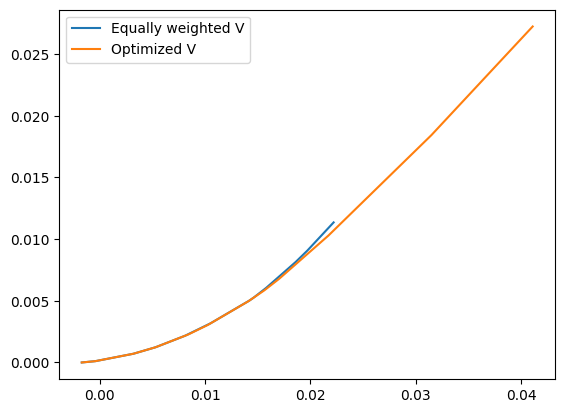

In [17]:
plt.plot(Y_returns,V,label="Equally weighted V")
plt.plot(X_returns,V_x,label="Optimized V")
plt.legend()